In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# https://github.com/efekarakus/potter-network/tree/master/data
# Данные о взаимоотношениях героев "Гарри Поттера"
sec_data = pd.read_csv('C:/Users/vhaim/Documents/relations.csv') # директория / URL-ссылка
sec_data

,source,target,type
0,0,1,-
1,0,25,-
2,0,45,-
3,1,0,-
4,1,11,+
...,...,...,...
508,63,58,-
509,64,21,+
510,64,22,+
511,64,39,+


In [3]:
right_data = np.array(sec_data)
aj_matr = np.eye(65)
for i in right_data:
    if i[1] != i[0]:
        if i[2] == '+':
            aj_matr[int(i[0]), int(i[1])] = 1
        else:
            aj_matr[int(i[0]), int(i[1])] = -1

In [4]:
%%time
# Преобразуем ориентированный граф в неориентированный
adj_matr = np.eye(65)
for i in range(len(adj_matr)):
    for j in range(i + 1, len(adj_matr)):
        if aj_matr[i, j] < 0 or aj_matr[j, i] < 0:
            adj_matr[i, j], adj_matr[j, i] = min(aj_matr[i, j], aj_matr[j, i]), min(aj_matr[i, j], aj_matr[j, i])
        else:
            adj_matr[i, j], adj_matr[j, i] = (aj_matr[i, j] + aj_matr[j, i]) / 2, (aj_matr[i, j] + aj_matr[j, i]) / 2
# Проверка симметричности полученной матрицы:
np.sum(adj_matr != np.transpose(adj_matr))

CPU times: total: 0 ns
Wall time: 5 ms


0

In [5]:
class SignGraph:
    """
    Matrix representation of a sign graph
    :param graph_matrix: graph in matrix form
    """
    def __init__(self, graph_matrix: np.array) -> None:
        self.matr_adj = graph_matrix
    
    def __str__(self) -> str:
        return f"It's a sign graph with matrix of relations with shape {np.shape(self.matr_pres)}"
        
    def __repr__(self) -> str:
        return f"It's a sign graph with matrix of relations with shape {np.shape(self.matr_pres)}"
    
    # Функции общего назначения
    def matr_trans(my_matr: np.array, right_dict: dict) -> np.array:
        ret_matr = deepcopy(my_matr)
        order_list = np.array(np.hstack(list(right_dict.values())) - 1, dtype=int)
        ret_matr = ret_matr[order_list, :]
        ret_matr = ret_matr[:, order_list]
        return ret_matr

    def alpha_matr(clust_dict: dict, alpha=0.5) -> np.array:
        for i in clust_dict:
            if i == 1:
                matr_alpha = np.ones((len(clust_dict[i]), len(clust_dict[i]))) * alpha
            else:
                sub_matr_0 = np.ones((len(clust_dict[i]), matr_alpha.shape[1])) * (alpha - 1)
                sub_matr_1 = np.ones((len(clust_dict[i]), len(clust_dict[i]))) * alpha
                down_matr = np.hstack((sub_matr_0, sub_matr_1))
                matr_alpha = np.hstack((matr_alpha, np.transpose(sub_matr_0)))
                matr_alpha = np.vstack((matr_alpha, down_matr))
        return matr_alpha

    def error_counter(adj_matr: np.array, clust_dict: dict, alpha=0.5) -> float:
        alpha_mat = SignGraph.alpha_matr(clust_dict, alpha=alpha)
        res_error = list(map(lambda x: x * (x < 0), np.multiply(adj_matr, alpha_mat)))
        return abs(np.sum(res_error))

    def completer(exist_dict: dict, len_dict: int) -> dict:
        if len(exist_dict) != 0:
            sub_dict = deepcopy(exist_dict)
            no_added_nod = list(set(np.arange(1, len_dict + 1)) - set(np.hstack(list(exist_dict.values()))))
            for i in range(len(exist_dict) + 1, len(exist_dict) + 1 + len(no_added_nod)):
                sub_dict[i] = [no_added_nod[i - len(exist_dict) - 1]]
        else:
            sub_dict = dict()
            for i in range(len_dict):
                sub_dict[i + 1] = [i + 1]
        return sub_dict
    
    # Кластеризация при помощи S-метода
    def s_method_clust(self) -> dict:
        s_dict = dict()
        matr_adj_r = np.array(list(map(lambda x: x * (x > 0), self.matr_adj)))
        for i in range(len(matr_adj_r)):
            s_dict[i + 1] = []
            for j in range(len(matr_adj_r[i])):
                if matr_adj_r[i, j] > 0:
                    s_dict[i + 1] += [j + 1]
        sort_order_vertices = sorted(s_dict, key=lambda x: len(s_dict[x]), 
                                     reverse=True)
        clust_dict = dict()
        k = 1
        while len(sort_order_vertices) > 0:
            sub_order = deepcopy(sort_order_vertices)        
            clust_dict[k] = []
            for i in sort_order_vertices:
                if set(s_dict[i]) <= set(s_dict[sort_order_vertices[0]]):
                    sub_order.remove(i)
                    clust_dict[k] += [i]
            sort_order_vertices = sub_order
            k += 1
        return clust_dict
    
    # Вспомогательные функции для метода FCSG
    def teta_matrs(matr_adj: np.array) -> np.array:
        matr_tet = deepcopy(matr_adj)
        matr_tet = matr_tet - np.eye(len(matr_tet))
        fir_matr_adj = np.where(matr_tet < 0, 0, matr_tet)
        sec_matr_adj = np.abs(matr_adj) - np.eye(len(matr_adj))
        res_matr_1 = np.array(list(map(lambda x: x / np.sum(x) if sum(x) != 0 else x, fir_matr_adj)))
        res_matr_2 = np.array(list(map(lambda x: x / np.sum(x) if sum(x) != 0 else x, sec_matr_adj)))
        return res_matr_1, res_matr_2

    def rwg(matr_adj: np.array, matr_tet_1: np.array, matr_tet_2: np.array, l: int) -> np.array:
        h_g_matr_1 = np.zeros((len(matr_adj), len(matr_adj)))
        h_g_matr_2 = np.zeros((len(matr_adj), len(matr_adj)))
        for i in range(1, l + 1):
            h_g_matr_1 = h_g_matr_1 + np.linalg.matrix_power(matr_tet_1, i)
            h_g_matr_2 = h_g_matr_2 + np.linalg.matrix_power(matr_tet_2, i)
        d_matr = (h_g_matr_2 - h_g_matr_1) / np.where(h_g_matr_1 == 0, 0.00001, h_g_matr_1)
        d_matr_right = np.array(list(map(lambda x: abs(x  * (x > 0)),d_matr)))
        h_res = np.exp(-0.5 * (d_matr_right + np.transpose(d_matr_right)))
        return (matr_adj - np.eye(len(matr_adj))) *  (h_res * np.array(matr_adj >= 0) +
                                                      np.ones((len(matr_adj), len(matr_adj))) * 
                                                      np.array(matr_adj < 0))
    
    # Кластеризация при помощи метода FCSG
    def fcsg_clust(self, l: int) -> dict:
        tet_matr_1, tet_matr_2 = SignGraph.teta_matrs(self.matr_adj)
        new_matr_adj = SignGraph.rwg(self.matr_adj, tet_matr_1, tet_matr_2, l)
        sub_matr_adj = deepcopy(new_matr_adj)
        clust_dict = dict()
        for i in range(len(sub_matr_adj)):
            clust_dict[i + 1] = [i + 1]
        while np.max(sub_matr_adj) > 0:
            indexes = np.array(np.where(sub_matr_adj == np.max(sub_matr_adj))).transpose()[0]
            i, j = min(indexes), max(indexes)
            sub_matr_adj[i, :], sub_matr_adj[:, i] = (sub_matr_adj[i, :] + sub_matr_adj[j, :], 
                                                      sub_matr_adj[:, i] + sub_matr_adj[:, j])
            sub_matr_adj[i, i] = 0
            sub_matr_adj = sub_matr_adj[~(np.arange(len(sub_matr_adj)) == j), :]
            sub_matr_adj = sub_matr_adj[:, ~(np.arange(len(sub_matr_adj) + 1) == j)]
            clust_dict[i + 1] += clust_dict[j + 1]
            if j + 1 == len(clust_dict):
                clust_dict.pop(j + 1)
            else:
                for k in range(j + 1, len(clust_dict)):
                    if k == len(clust_dict) - 1:
                        clust_dict[k] = clust_dict[k + 1]
                        clust_dict.pop(k + 1)
                    else:
                        clust_dict[k] = clust_dict[k + 1]
        return clust_dict
    
    # Вспомогательные функции для метода Min-Error
    def rand_generation(n: int, k: int) -> dict:
        res = dict()
        vert_list = list(range(1, n + 1))
        borders = list(range(1, n))
        np.random.shuffle(vert_list)
        borders_sort = sorted(np.random.choice(borders, size = k - 1, replace = False))
        for i in range(k - 1):
            if i == 0:
                res[1] = vert_list[:borders_sort[0]]
                if k == 2:
                    res[2] = vert_list[borders_sort[0]:]
            elif i == (k - 2):
                res[k - 1] = vert_list[borders_sort[i - 1]:borders_sort[i]]
                res[k] = vert_list[borders_sort[i]:]
            else:
                res[i + 1] = vert_list[borders_sort[i - 1]:borders_sort[i]]
        return res

    # Кластеризация при помощи метода Min-Error
    def min_error_clust(self, k_clust: int, l_times: int, alpha=0.5) -> dict:
        my_matr = self.matr_adj
        list_of_results = list()
        for l in range(l_times):
            clust_dict = SignGraph.rand_generation(my_matr.shape[0], k_clust)
            while True:
                first_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
                for i in clust_dict:
                    for j in clust_dict[i]:
                        list_of_errors = list()
                        new_dict = deepcopy(clust_dict)
                        new_dict[i].remove(j)
                        for k in clust_dict:
                            if j not in clust_dict[k]:
                                new_dict[k].append(j)
                                sub_adj = SignGraph.matr_trans(my_matr, new_dict)
                                list_of_errors.append((SignGraph.error_counter(sub_adj, new_dict, alpha), 
                                                       deepcopy(new_dict)))
                                new_dict[k].pop(-1)
                        best_res = min(list_of_errors, key=lambda x: x[0])
                        if SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha) > best_res[0]:
                            clust_dict = best_res[1]
                last_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
                if first_error == last_error:
                    break
            list_of_results.append((last_error, clust_dict))
        res_clust_dict = min(list_of_results, key=lambda x: x[0])[1]
        return res_clust_dict

    # Функция для подсчета таймингов выполения каждого подперемещения для алгоритма FCSG
    def fcsg_clust_cps(self, l: int) -> (dict, list, list, int):
        my_matr = self.matr_adj
        clust_dict = dict()
        ticks = np.array([])
        errors = np.array([])
        sub_sub_dict = SignGraph.completer(clust_dict, len(my_matr))
        t_0 = time.perf_counter()
        ticks = np.append(ticks, t_0 - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
        tet_matr_1, tet_matr_2 = SignGraph.teta_matrs(my_matr)
        new_matr_adj = SignGraph.rwg(my_matr, tet_matr_1, tet_matr_2, l)
        sub_matr_adj = deepcopy(new_matr_adj)
        for i in range(len(sub_matr_adj)):
            clust_dict[i + 1] = [i + 1]
        sub_sub_dict = SignGraph.completer(clust_dict, len(my_matr))
        ticks = np.append(ticks, time.perf_counter() - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
        while np.max(sub_matr_adj) > 0:
            indexes = np.array(np.where(sub_matr_adj == np.max(sub_matr_adj))).transpose()[0]
            i, j = min(indexes), max(indexes)
            sub_matr_adj[i, :], sub_matr_adj[:, i] = (sub_matr_adj[i, :] + sub_matr_adj[j, :], 
                                                      sub_matr_adj[:, i] + sub_matr_adj[:, j])
            sub_matr_adj[i, i] = 0
            sub_matr_adj = sub_matr_adj[~(np.arange(len(sub_matr_adj)) == j), :]
            sub_matr_adj = sub_matr_adj[:, ~(np.arange(len(sub_matr_adj) + 1) == j)]
            clust_dict[i + 1] += clust_dict[j + 1]
            if j + 1 == len(clust_dict):
                clust_dict.pop(j + 1)
            else:
                for k in range(j + 1, len(clust_dict)):
                    if k == len(clust_dict) - 1:
                        clust_dict[k] = clust_dict[k + 1]
                        clust_dict.pop(k + 1)
                    else:
                        clust_dict[k] = clust_dict[k + 1]
            sub_sub_dict = SignGraph.completer(clust_dict, len(my_matr))
            ticks = np.append(ticks, time.perf_counter() - t_0)
            errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
        return clust_dict, ticks, errors, t_0
    
    # Функция для подсчета таймингов выполения каждого подперемещения для алгоритма S-method
    def s_method_cps(self) -> (list, list):
        my_matr = self.matr_adj
        sub_dict = dict()
        ticks = np.array([])
        errors = np.array([])
        sub_sub_dict = SignGraph.completer(sub_dict, len(my_matr))
        t_0 = time.perf_counter()
        ticks = np.append(ticks, t_0 - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
        s_dict = dict()
        matr_adj_r = np.array(list(map(lambda x: x * (x > 0), my_matr)))
        for i in range(len(matr_adj_r)):
            s_dict[i + 1] = []
            for j in range(len(matr_adj_r[i])):
                if matr_adj_r[i, j] > 0:
                    s_dict[i + 1] += [j + 1]
        sort_order_vertices = sorted(s_dict, key=lambda x: len(s_dict[x]), 
                                     reverse=True)
        clust_dict = dict()
        sub_sub_dict = SignGraph.completer(clust_dict, len(my_matr))
        ticks = np.append(ticks, time.perf_counter() - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
        k = 1
        while len(sort_order_vertices) > 0:
            sub_order = deepcopy(sort_order_vertices)        
            clust_dict[k] = []
            for i in sort_order_vertices:
                if set(s_dict[i]) <= set(s_dict[sort_order_vertices[0]]):
                    sub_order.remove(i)
                    clust_dict[k] += [i]
                    sub_sub_dict = SignGraph.completer(clust_dict, len(my_matr))
                    ticks = np.append(ticks, time.perf_counter() - t_0)
                    errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr,sub_sub_dict),sub_sub_dict))
            sort_order_vertices = sub_order
            k += 1
        return ticks, errors
    
    # Функция для подсчета таймингов выполения каждого подперемещения для алгоритма Min-Error
    def min_error_clust_cps(self, k_clust: int, l_times: int, alpha=0.5) -> (list, list):
        my_matr = self.matr_adj
        ticks = np.array([])
        errors = np.array([])
        list_of_results = list()
        for l in range(l_times):
            sub_dict = dict()
            sub_sub_dict = SignGraph.completer(sub_dict, len(my_matr))
            t_0 = time.perf_counter()
            ticks = np.append(ticks, t_0 - t_0)
            errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, sub_sub_dict), sub_sub_dict))
            clust_dict = SignGraph.rand_generation(my_matr.shape[0], k_clust)
            ticks = np.append(ticks, time.perf_counter() - t_0)
            errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict))
            while True:
                first_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
                for i in clust_dict:
                    for j in clust_dict[i]:
                        list_of_errors = list()
                        new_dict = deepcopy(clust_dict)
                        new_dict[i].remove(j)
                        for k in clust_dict:
                            if j not in clust_dict[k]:
                                new_dict[k].append(j)
                                sub_adj = SignGraph.matr_trans(my_matr, new_dict)
                                list_of_errors.append((SignGraph.error_counter(sub_adj, new_dict, alpha), 
                                                       deepcopy(new_dict)))
                                new_dict[k].pop(-1)
                        best_res = min(list_of_errors, key=lambda x: x[0])
                        if SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha) > best_res[0]:
                            clust_dict = best_res[1]
                            ticks = np.append(ticks, time.perf_counter() - t_0)
                            sub_matrix = SignGraph.matr_trans(my_matr,clust_dict)
                            errors = np.append(errors, SignGraph.error_counter(sub_matrix, clust_dict))
                last_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
                if first_error == last_error:
                    break
            list_of_results.append((last_error, clust_dict))
        res_clust_dict = min(list_of_results, key=lambda x: x[0])[1]
        ticks = np.append(ticks, time.perf_counter() - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, res_clust_dict), res_clust_dict))
        return ticks, errors
    
    # Композиция двух методов кластеризации FCSG и Min-Error
    def composition_method(self, l: int, alpha=0.5) -> (dict, list, list):
        my_matr = self.matr_adj
        clust_dict, ticks, errors, t_0 = SignGraph.fcsg_clust_cps(self, l)
        while True:
            first_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
            for i in clust_dict:
                for j in clust_dict[i]:
                    list_of_errors = list()
                    new_dict = deepcopy(clust_dict)
                    new_dict[i].remove(j)
                    for k in clust_dict:
                        if j not in clust_dict[k]:
                            new_dict[k].append(j)
                            sub_adj = SignGraph.matr_trans(my_matr, new_dict)
                            list_of_errors.append((SignGraph.error_counter(sub_adj, new_dict, alpha), 
                                                       deepcopy(new_dict)))
                            new_dict[k].pop(-1)
                    best_res = min(list_of_errors, key=lambda x: x[0])
                    if SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha) > best_res[0]:
                        clust_dict = best_res[1]
                        ticks = np.append(ticks, time.perf_counter() - t_0)
                        sub_matrix = SignGraph.matr_trans(my_matr, clust_dict)
                        errors = np.append(errors, SignGraph.error_counter(sub_matrix, clust_dict))
            last_error = SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict, alpha)
            if first_error == last_error:
                break
        ticks = np.append(ticks, time.perf_counter() - t_0)
        errors = np.append(errors, SignGraph.error_counter(SignGraph.matr_trans(my_matr, clust_dict), clust_dict))
        return clust_dict, ticks, errors

In [6]:
%%time
harry_potter_graph = SignGraph(adj_matr)
h_p_f_dict = harry_potter_graph.fcsg_clust(l = 25)
h_p_f_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_f_dict), h_p_f_dict)
print(f'Ошибка распределения согласно методу FCSG: {h_p_f_error}')
print('')

Ошибка распределения согласно методу FCSG: 11.5

CPU times: total: 15.6 ms
Wall time: 18 ms


In [7]:
%%time
h_p_s_dict = harry_potter_graph.s_method_clust()
h_p_s_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_s_dict), h_p_s_dict)
print(f'Ошибка распределения согласно S-методу: {h_p_s_error}')
print('')

Ошибка распределения согласно S-методу: 99.5

CPU times: total: 0 ns
Wall time: 5 ms


In [8]:
%%time
h_p_mec_dict = harry_potter_graph.min_error_clust(k_clust = 3, l_times = 10)
h_p_mec_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_mec_dict), h_p_mec_dict)
print(f'Ошибка распределения согласно методу M-E: {h_p_mec_error}')
print('')

Ошибка распределения согласно методу M-E: 9.5

CPU times: total: 3.53 s
Wall time: 2.67 s


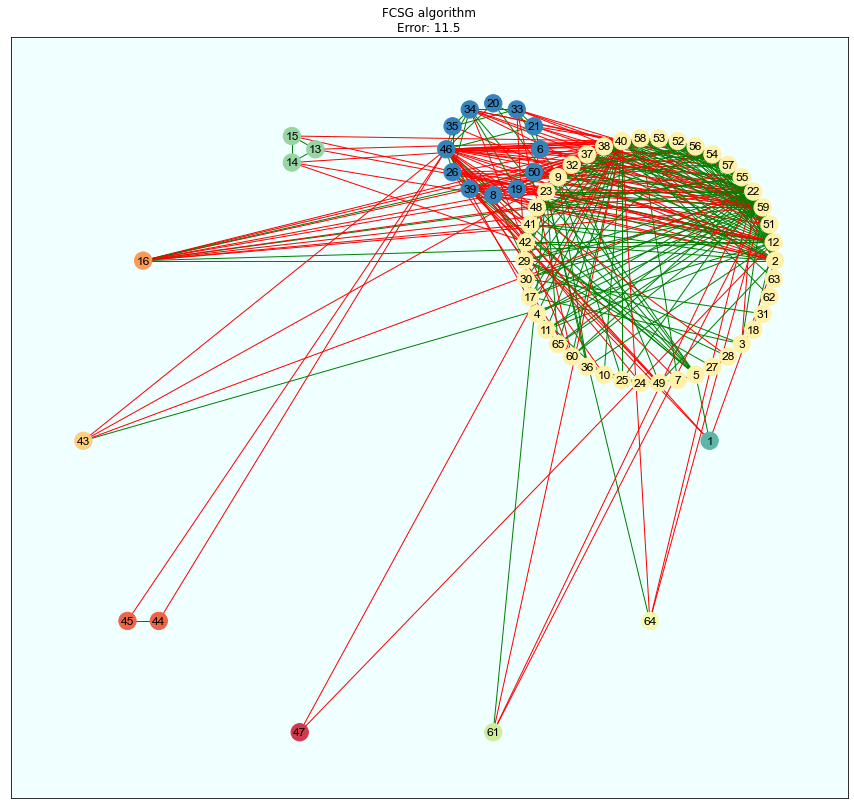

In [9]:
# Визаулизация полученного разбиения согласно методу FCSG 
G = nx.Graph(adj_matr-np.eye(65))
G = nx.relabel_nodes(G, dict(zip(np.arange(65), np.arange(1, 66))))
col_map = sns.color_palette("Spectral", len(h_p_f_dict))
np.random.seed(26)
np.random.shuffle(col_map)
col_map_nod = list()
for i in range(65):
    for j in h_p_f_dict:
        if (i + 1) in h_p_f_dict[j]:
            col_map_nod.append(col_map[j - 1])
col_map_edg = list()
for i in G.edges(data=True):
    if i[2]['weight'] < 0:
        col_map_edg.append('red')
    if i[2]['weight'] > 0:
        col_map_edg.append('green')
pos = dict()
fir_pos = nx.circular_layout(np.arange(len(h_p_f_dict)), scale=20)
for i in h_p_f_dict:
    sub_pos = nx.circular_layout(np.arange(len(h_p_f_dict[i])), center=fir_pos[i - 1], scale=1 + (len(h_p_f_dict[i]) // 6))
    for j in range(len(h_p_f_dict[i])):
        pos[h_p_f_dict[i][j]] = sub_pos[j]
f_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_f_dict), h_p_f_dict)
my_fig = plt.figure(figsize=(15, 14))
my_pic = plt.subplot()
my_pic.axes.xaxis.set_ticks([])
my_pic.axes.yaxis.set_ticks([])
my_pic.set_facecolor('azure')
my_fig.set_facecolor('white')
plt.title('FCSG algorithm' + '\n' + f'Error: {f_error}')
nx.draw(G, ax=my_fig.add_subplot(1, 1, 1), with_labels=True, node_size=300, node_color=col_map_nod, 
        edge_color=col_map_edg, pos = pos, font_family='Arial', font_size=12)
# my_fig.savefig('FCSG.png', dpi=1000)

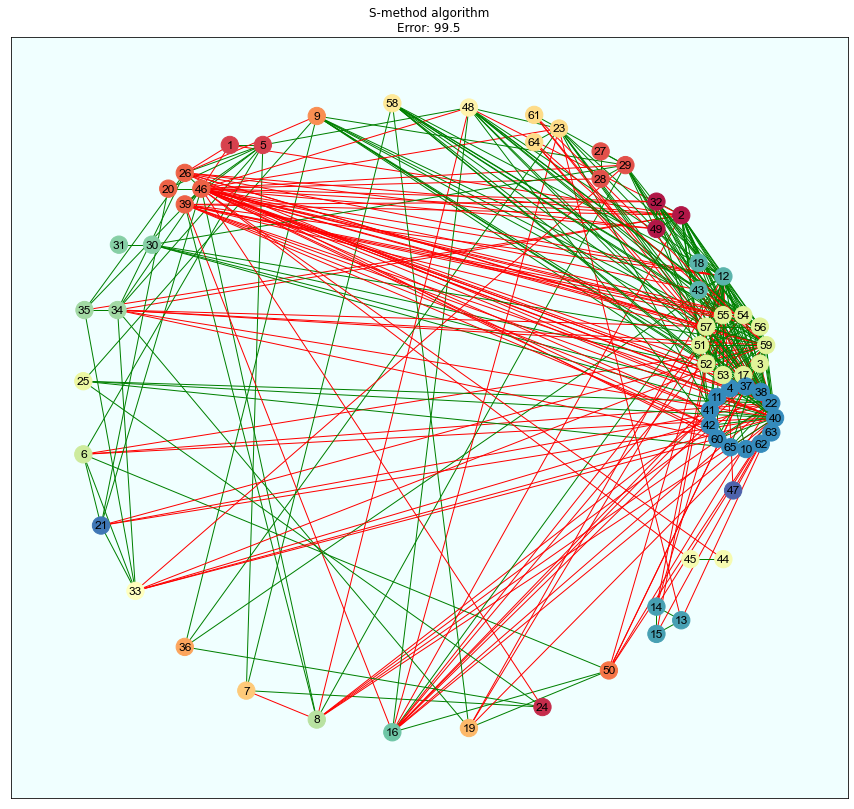

In [10]:
# Визаулизация полученного разбиения согласно методу S-method
G = nx.Graph(adj_matr-np.eye(65))
G = nx.relabel_nodes(G, dict(zip(np.arange(65), np.arange(1, 66))))
col_map = sns.color_palette("Spectral", len(h_p_s_dict))
np.random.seed(4)
np.random.shuffle(col_map)
col_map_nod = list()
for i in range(65):
    for j in h_p_s_dict:
        if (i + 1) in h_p_s_dict[j]:
            col_map_nod.append(col_map[j - 1])
col_map_edg = list()
for i in G.edges(data=True):
    if i[2]['weight'] < 0:
        col_map_edg.append('red')
    if i[2]['weight'] > 0:
        col_map_edg.append('green')
pos = dict()
fir_pos = nx.circular_layout(np.arange(len(h_p_s_dict)), scale=20)
for i in h_p_s_dict:
    sub_pos = nx.circular_layout(np.arange(len(h_p_s_dict[i])), center=fir_pos[i - 1], scale=1 + (len(h_p_s_dict[i]) // 10))
    for j in range(len(h_p_s_dict[i])):
        pos[h_p_s_dict[i][j]] = sub_pos[j]
s_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_s_dict), h_p_s_dict)
my_fig = plt.figure(figsize=(15, 14))
my_pic = plt.subplot()
my_pic.axes.xaxis.set_ticks([])
my_pic.axes.yaxis.set_ticks([])
my_pic.set_facecolor('azure')
my_fig.set_facecolor('white')
plt.title('S-method algorithm' + '\n' + f'Error: {s_error}')
nx.draw(G, ax=my_fig.add_subplot(1, 1, 1), with_labels=True, node_size=300, node_color=col_map_nod, 
        edge_color=col_map_edg, pos = pos, font_family='Arial', font_size=12)
# my_fig.savefig('S-meth.png', dpi=1000)

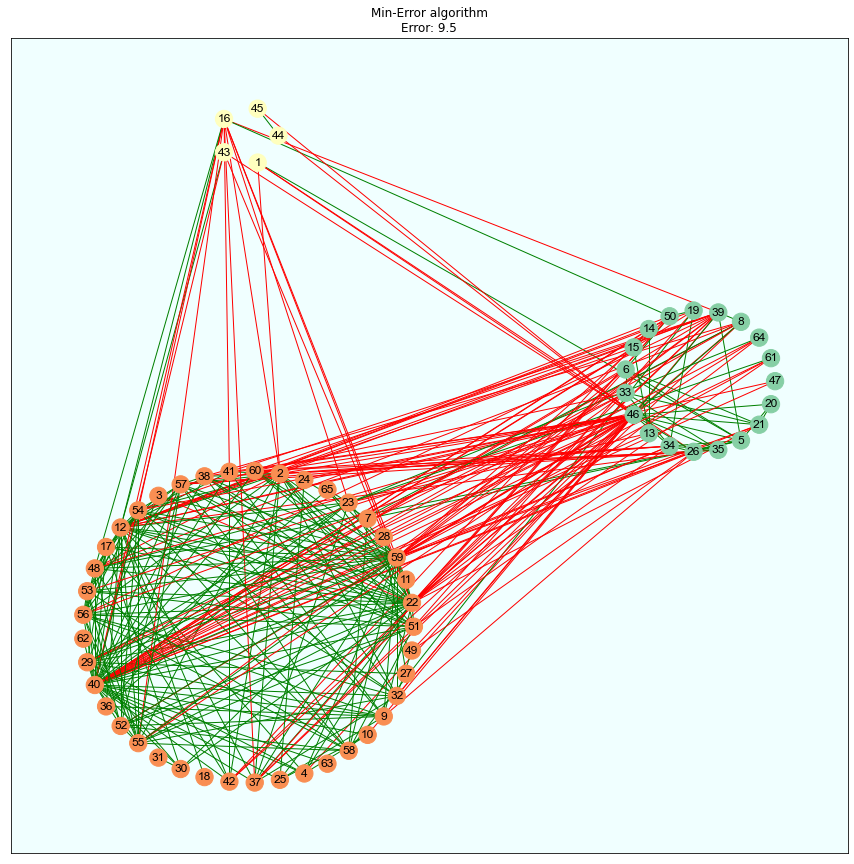

In [11]:
# Визаулизация полученного разбиения согласно методу Min-Error
G = nx.Graph(adj_matr-np.eye(65))
G = nx.relabel_nodes(G, dict(zip(np.arange(65), np.arange(1, 66))))
col_map = sns.color_palette("Spectral", len(h_p_mec_dict))
np.random.seed(2)
np.random.shuffle(col_map)
col_map_nod = list()
for i in range(65):
    for j in h_p_mec_dict:
        if (i + 1) in h_p_mec_dict[j]:
            col_map_nod.append(col_map[j - 1])
col_map_edg = list()
for i in G.edges(data=True):
    if i[2]['weight'] < 0:
        col_map_edg.append('red')
    if i[2]['weight'] > 0:
        col_map_edg.append('green')
pos = dict()
fir_pos = nx.circular_layout(np.arange(len(h_p_mec_dict)), scale=20)
for i in h_p_mec_dict:
    sub_pos = nx.circular_layout(np.arange(len(h_p_mec_dict[i])), center=fir_pos[i - 1], scale=1 + (len(h_p_mec_dict[i]) // 4))
    for j in range(len(h_p_mec_dict[i])):
        pos[h_p_mec_dict[i][j]] = sub_pos[j]
m_error = SignGraph.error_counter(SignGraph.matr_trans(adj_matr, h_p_mec_dict), h_p_mec_dict)
my_fig = plt.figure(figsize=(15, 15))
my_pic = plt.subplot()
my_pic.axes.xaxis.set_ticks([])
my_pic.axes.yaxis.set_ticks([])
my_pic.set_facecolor('azure')
my_fig.set_facecolor('white')
plt.title('Min-Error algorithm' + '\n' + f'Error: {m_error}')
nx.draw(G, ax=my_fig.add_subplot(1, 1, 1), with_labels=True, node_size=300, node_color=col_map_nod, 
        edge_color=col_map_edg, pos = pos, font_family='Arial', font_size=12)
# my_fig.savefig('M-E.png', dpi=1000)

In [12]:
%%time
fcsg_dict, fcsg_ticks, fcsg_errors, f_t_0 = harry_potter_graph.fcsg_clust_cps(l = 20)
s_ticks, s_errors = harry_potter_graph.s_method_cps()
comp_dict, comp_ticks, comp_errors = harry_potter_graph.composition_method(l = 20)

CPU times: total: 2.89 s
Wall time: 921 ms


In [13]:
%%time
# Агрегация наблюдаемых зависимостей ошибки от времени для метода Min-Error и параметре k_clust = 3 
mec_ticks_3, mec_errors_3 = harry_potter_graph.min_error_clust_cps(k_clust = 3, l_times = 1)
pairs = list(zip(mec_ticks_3, mec_errors_3))
for i in range(10):
    a, b = harry_potter_graph.min_error_clust_cps(k_clust = 3, l_times = 1)
    sub_pairs = list(zip(a, b))
    pairs += sub_pairs
pairs_right_order = sorted(pairs, key=lambda x: x[0])
matr_res = np.array(pairs_right_order)
m_ticks, m_errors = matr_res[:, 0], matr_res[:, 1]

CPU times: total: 2.78 s
Wall time: 2.77 s


In [14]:
%%time
# Агрегация наблюдаемых зависимостей ошибки от времени для метода Min-Error и параметре k_clust = 5
mec_ticks_5, mec_errors_5 = harry_potter_graph.min_error_clust_cps(k_clust = 5, l_times = 1)
pairs = list(zip(mec_ticks_5, mec_errors_5))
for i in range(10):
    a, b = harry_potter_graph.min_error_clust_cps(k_clust = 5, l_times = 1)
    sub_pairs = list(zip(a, b))
    pairs += sub_pairs
pairs_right_order = sorted(pairs, key=lambda x: x[0])
matr_res = np.array(pairs_right_order)
m_ticks, m_errors = matr_res[:, 0], matr_res[:, 1]

CPU times: total: 5.42 s
Wall time: 5.46 s


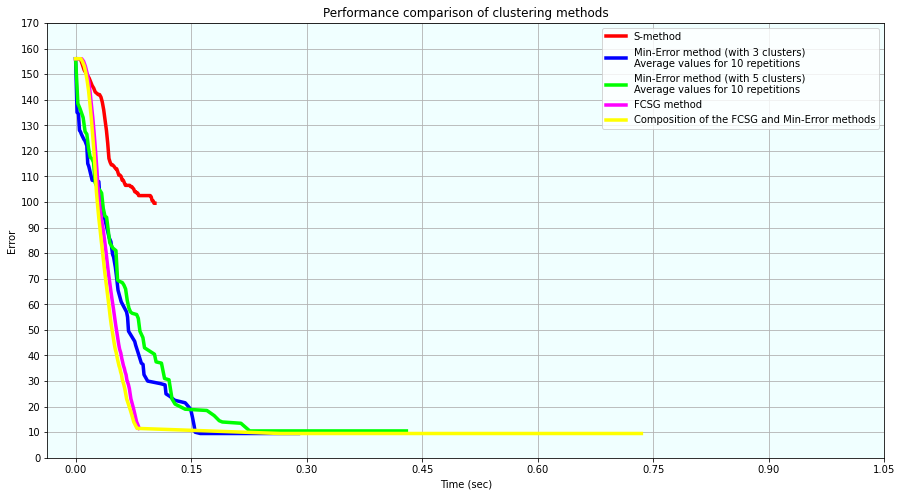

In [15]:
# Построение графиков зависимостей разных алгоритмов (ошибка от времени)
fig = plt.figure(figsize=(15, 8))
my_pic = plt.subplot(1, 1, 1)
my_pic.plot(s_ticks, s_errors, label='S-method', color='red', linewidth=3.5)
my_pic.plot(mec_ticks_3, mec_errors_3, label='Min-Error method (with 3 clusters)' +'\n'+ 'Average values for 10 repetitions', 
            color='blue', linewidth=3.5)
my_pic.plot(mec_ticks_5, mec_errors_5, label='Min-Error method (with 5 clusters)' +'\n'+ 'Average values for 10 repetitions', 
            color='lime', linewidth=3.5)
my_pic.plot(fcsg_ticks, fcsg_errors, label='FCSG method', color='fuchsia', linewidth=3.5)
my_pic.plot(comp_ticks, comp_errors, label='Composition of the FCSG and Min-Error methods', color='yellow', linewidth=3.5)
my_pic.set_yticks(np.arange(0, 171, 10))
my_pic.set_xticks(np.arange(0, 1.10, 0.15))
my_pic.set_facecolor('azure')
fig.set_facecolor('white')
plt.xlabel('Time (sec)')
plt.ylabel('Error')
plt.title('Performance comparison of clustering methods')
plt.legend()
plt.grid()
# fig.savefig('Comparison.png', dpi=1000)